In [103]:
import h5py
import pandas as pd
import loss_function
import os

import numpy as np
from loss_function import descriptor_distance, unmapped_penalty
import solver
from scipy.optimize import linear_sum_assignment

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [104]:
if True:
    onebody = {}
    twobody = {}
    onebody_keys = []
    twobody_keys = []
    ai_descriptors = "../h4_data/ai_descriptors.csv"
    minimum_1s_occupation = 3.7
    onebody_params = ['E0','t']
    twobody_params = ['U']
    w_0 = 0.9
    lamb = 0.1
    with h5py.File("../h4_data/named_terms_new.hdf5", "r") as f:
        for k in f["onebody"].keys():
            onebody[k] = f[f"onebody/{k}"][()]
            onebody_keys.append(k)
        for k in f["twobody"].keys():
            twobody[k] = f[f"twobody/{k}"][:]
            twobody_keys.append(k)
    ai_df = pd.read_csv(ai_descriptors)
    ai_df = ai_df[ai_df.E0 > minimum_1s_occupation]
    ai_df = ai_df[ai_df.U < 1.3]  # Need to remove the top two states from the optimization

    matches = onebody_params + twobody_params

    w_1 = 1 - w_0

    weights = [w_0, w_1]

In [105]:
def evaluate_loss( # only evaluate penalty for k unmapped states
    params: np.ndarray,
    keys,
    onebody,
    twobody,
    ai_df,
    nroots,
    matches,
    norm,
    max_ai_energy= None,
    weights=[0.5,0.5],
) -> float:
   
    if max_ai_energy is None:
        max_ai_energy = np.max(ai_df["energy"])

    params = pd.Series(params, index=keys)

    descriptors, fcivec = solver.solve_effective_hamiltonian(
        onebody, twobody, params, nroots=nroots, ci0=None
    )

    dist_des = descriptor_distance(
        ai_df, descriptors, matches=matches, norm=norm
    )
    dist_energy = descriptor_distance(
        ai_df, descriptors, matches=["energy"], norm=norm
    )
    distance = dist_energy + dist_des
    row_ind, col_ind = linear_sum_assignment(distance)

    sloss =  dist_energy
    dloss = dist_des
    not_col_ind = np.delete(np.arange(nroots), col_ind)

    penalty =  np.maximum(0,max_ai_energy-descriptors['energy'][not_col_ind])

    return {'sloss':sloss, 'dloss':dloss, 'penalty':penalty, 'row_ind':row_ind, 'col_ind':col_ind, 'not_col_ind':not_col_ind}


def new_evaluate_loss( # only evaluate penalty for all n model states
    params: np.ndarray,
    keys,
    onebody,
    twobody,
    ai_df,
    nroots,
    matches,
    norm,
    max_ai_energy= None,
    weights=[0.5,0.5],
) -> float:
   
    if max_ai_energy is None:
        max_ai_energy = np.max(ai_df["energy"])

    params = pd.Series(params, index=keys)

    descriptors, fcivec = solver.solve_effective_hamiltonian(
        onebody, twobody, params, nroots=nroots, ci0=None
    )

    dist_des = descriptor_distance(
        ai_df, descriptors, matches=matches, norm=norm
    )
    dist_energy = descriptor_distance(
        ai_df, descriptors, matches=["energy"], norm=norm
    )
    distance = dist_energy + dist_des

    sloss =  dist_energy
    dloss = dist_des

    penalty =  np.maximum(0,max_ai_energy-descriptors['energy'])

    distance = np.vstack((distance, np.tile(penalty, (6,1))))

    row_ind, col_ind = linear_sum_assignment(distance)

    return {'sloss':sloss, 'dloss':dloss, 'penalty':penalty, 'row_ind':row_ind, 'col_ind':col_ind, 'distance':distance}

In [106]:
# Use these functions if ai_df.drop(p_out_states, axis=0) was used
def insert_missing_back(dist_dict, p_out_states):

    p_out_states = np.sort(p_out_states) # so that insert is at the right index

    sloss = np.insert(dist_dict["sloss"], p_out_states, 0, axis=0)
    dloss = np.insert(dist_dict["dloss"], p_out_states, 0, axis=0)

    row_ind = dist_dict["row_ind"]

    for p in p_out_states:
        ind = np.where(row_ind == p)[0][0]
        for i in range(ind, len(row_ind)):
            row_ind[i] += 1

    return {'sloss':sloss, 'dloss':dloss, 'penalty':dist_dict["penalty"], 'row_ind':row_ind, 'col_ind':dist_dict["col_ind"], 'not_col_ind':dist_dict["not_col_ind"]}

def insert_missing_back_2(dist_dict, p_out_states):

    p_out_states = np.sort(p_out_states) # so that insert is at the right index

    sloss = dist_dict["sloss"]
    dloss = dist_dict["dloss"]
    distance = dist_dict["distance"]

    row_ind = dist_dict["row_ind"]

    for p in p_out_states:

        sloss = np.insert(sloss, p, 0, axis=0)
        dloss = np.insert(dloss, p, 0, axis=0)
        distance = np.insert(distance, p, 0, axis=0)

        ind = np.where(row_ind == p)[0][0]
        for i in range(ind, len(row_ind)):
            row_ind[i] += 1

    return {'sloss':sloss, 'dloss':dloss, 'penalty':dist_dict["penalty"], 'row_ind':row_ind, 'col_ind':dist_dict["col_ind"], 'distance':distance}

In [107]:
def plot_loss(d, dpi=300):
    loss = d['sloss']+d['dloss']

    vmin = 0
    vmax = np.max(np.sqrt(loss))
    pad = 0.5

    fig = plt.figure(layout="constrained", dpi=dpi)
    axes = fig.subplot_mosaic("""
                                AAAAAA
                                .....B
                                """,
                                height_ratios=[1, 6/30])

    cmap = axes['A'].imshow(np.sqrt(loss), cmap = 'Blues_r', vmin=vmin, vmax=vmax)
    for i in range(len(d['row_ind'])):
        axes['A'].add_patch(patches.Circle((d['col_ind'][i], d['row_ind'][i]), 0.2, facecolor='r'))
    axes['A'].set_title("Energy loss + Descriptor loss")
    axes['A'].set_xlabel("Model States")
    axes['A'].set_ylabel("Ab initio States")

    cmap = axes['B'].imshow(np.tile(np.sqrt(d['penalty']), (6,1)), cmap = 'Blues_r', vmin=vmin, vmax=vmax)
    axes['B'].set_title("Penalty")
    axes['B'].set_xticks([0, 5], labels=[30,35])
    axes['B'].set_yticks([0, 5], labels=['?','?'])

    fig.colorbar(cmap, ax=[axes['A'], axes['B']], label='sqrt(loss)')

def plot_loss2(dist_dict, dpi=300): # use with new_evaluate_loss
    distance = np.vstack((dist_dict["sloss"]+dist_dict["dloss"], np.tile(dist_dict["penalty"], (6,1))))

    vmin = 0
    vmax = np.max(np.sqrt(distance))

    fig, ax = plt.subplots(layout="constrained", dpi=dpi)

    cmap = ax.imshow(np.sqrt(distance), cmap = 'Blues_r', vmin=vmin, vmax=vmax)

    for i in range(len(dist_dict['row_ind'])):
        ax.add_patch(patches.Circle((dist_dict['col_ind'][i], dist_dict['row_ind'][i]), 0.2, facecolor='r'))

    ax.set_title("Energy loss + Descriptor loss + Penalty")
    ax.set_xlabel("Model States")
    ax.set_ylabel("Ab initio States")

    fig.colorbar(cmap, ax=ax, label='sqrt(loss)')

### evaluate_loss()
Next couple of blocks evaluate and plot the old evaluate_loss function that only evaluated the penalty for the unmapped states.

In [108]:
d = evaluate_loss(params = [-.02, .33, -.5], 
              keys = ['t','U','E0'],  
              onebody = onebody, 
              twobody = twobody, 
              ai_df = ai_df, 
              nroots = 36, 
              matches = ['t','U'], 
              norm = 2 * np.var(ai_df),
              weights=weights)

/home/sjoshi/anaconda3/envs/pyscf_fci_bug/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


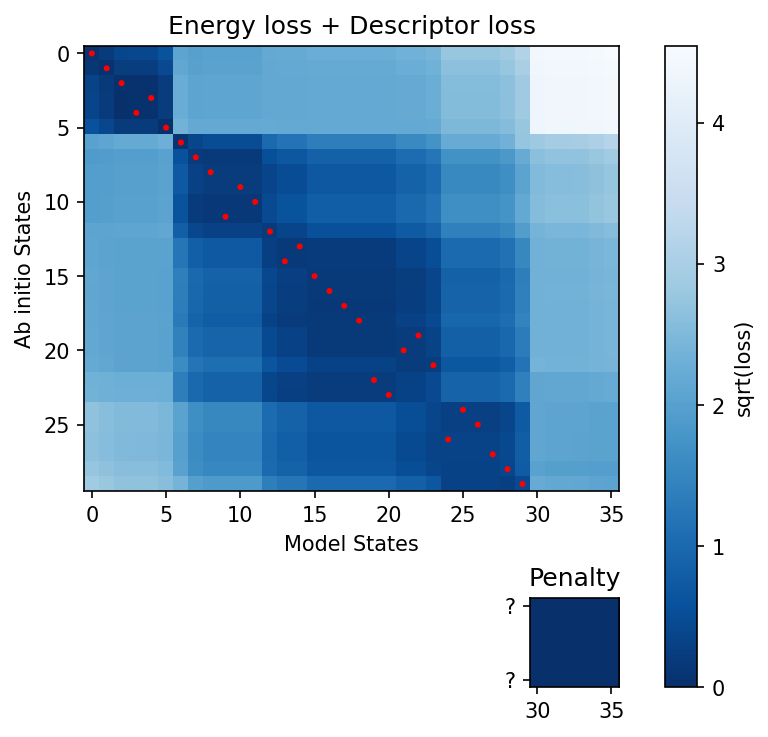

In [109]:
plot_loss(d, dpi=150)

In [110]:
p_out_states = [26]

d2 = evaluate_loss(params = [-.02, .33, -.5], 
              keys = ['t','U','E0'],  
              onebody = onebody, 
              twobody = twobody, 
              ai_df = ai_df.drop(p_out_states, axis=0), 
              nroots = 36, 
              matches = ['t','U'], 
              norm = 2 * np.var(ai_df),
              weights=weights,
              max_ai_energy=np.max(ai_df['energy']))

ai_df2 = ai_df.copy()
ai_df2.loc[p_out_states] = 0
d3 = evaluate_loss(params = [-.02, .33, -.5], 
              keys = ['t','U','E0'],  
              onebody = onebody, 
              twobody = twobody, 
              ai_df = ai_df2, 
              nroots = 36, 
              matches = ['t','U'], 
              norm = 2 * np.var(ai_df),
              weights=weights,
              max_ai_energy=np.max(ai_df['energy']))

/home/sjoshi/anaconda3/envs/pyscf_fci_bug/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/sjoshi/anaconda3/envs/pyscf_fci_bug/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


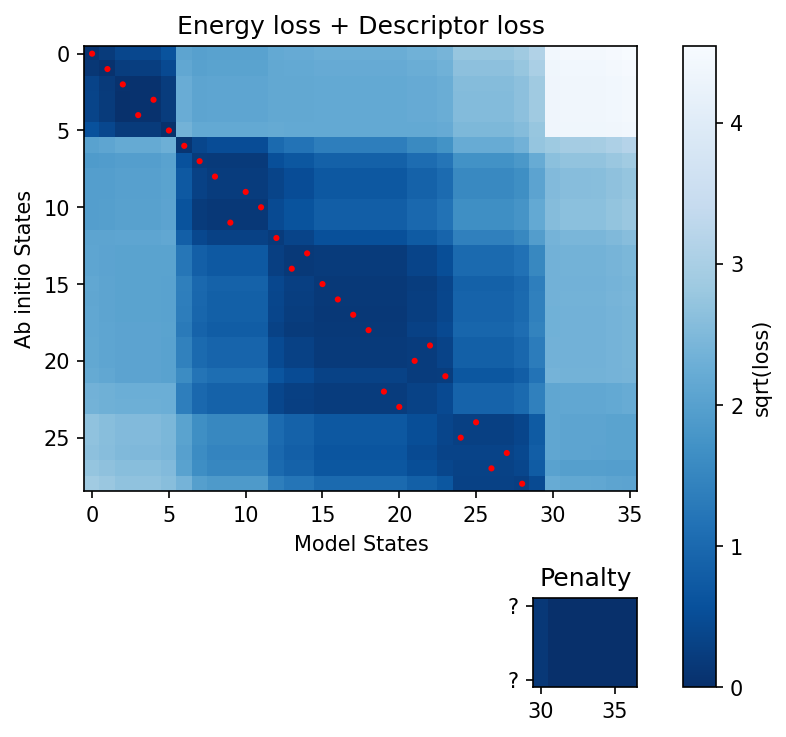

In [111]:
plot_loss(d2, dpi=150)

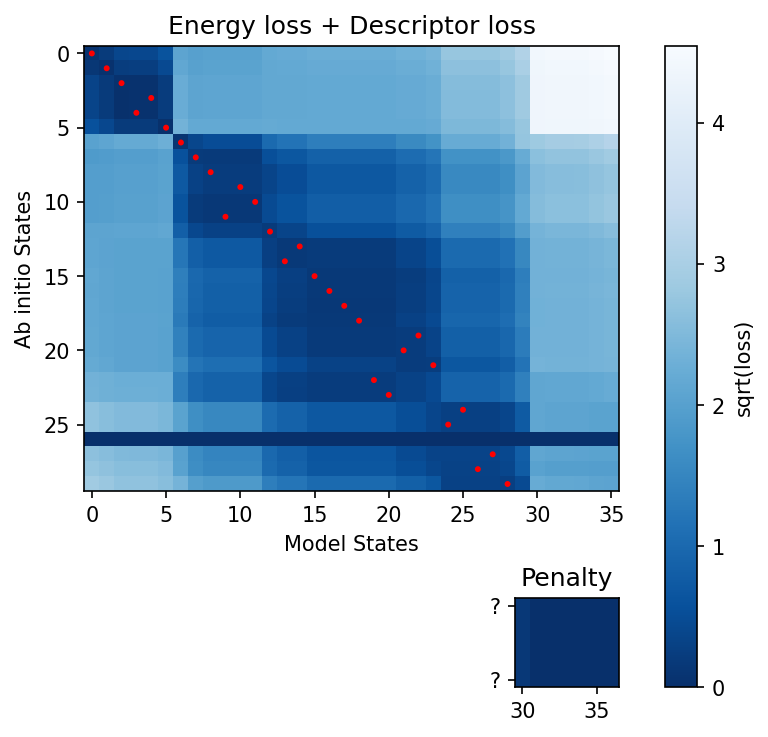

In [112]:
d2_new = insert_missing_back(d2, p_out_states)
plot_loss(d2_new, dpi=150)

### new_evaluate_loss()

This loss evaluation determines the penalty by adding it to the whole distance array. That way the mapping minimizes the penalty as well.

In [113]:
d_new = new_evaluate_loss(params = [-.02, .33, -.5], 
              keys = ['t','U','E0'],  
              onebody = onebody, 
              twobody = twobody, 
              ai_df = ai_df, 
              nroots = 36, 
              matches = ['t','U'], 
              norm = 2 * np.var(ai_df),
              weights=weights,
              max_ai_energy=np.max(ai_df['energy']))

d_oneout = new_evaluate_loss(params = [-.02, .33, -.5], 
              keys = ['t','U','E0'],  
              onebody = onebody, 
              twobody = twobody, 
              ai_df = ai_df.drop(p_out_states, axis=0), 
              nroots = 36, 
              matches = ['t','U'], 
              norm = 2 * np.var(ai_df),
              weights=weights,
              max_ai_energy=np.max(ai_df['energy']))

d_oneout_new = insert_missing_back_2(d_oneout, p_out_states)

/home/sjoshi/anaconda3/envs/pyscf_fci_bug/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/sjoshi/anaconda3/envs/pyscf_fci_bug/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


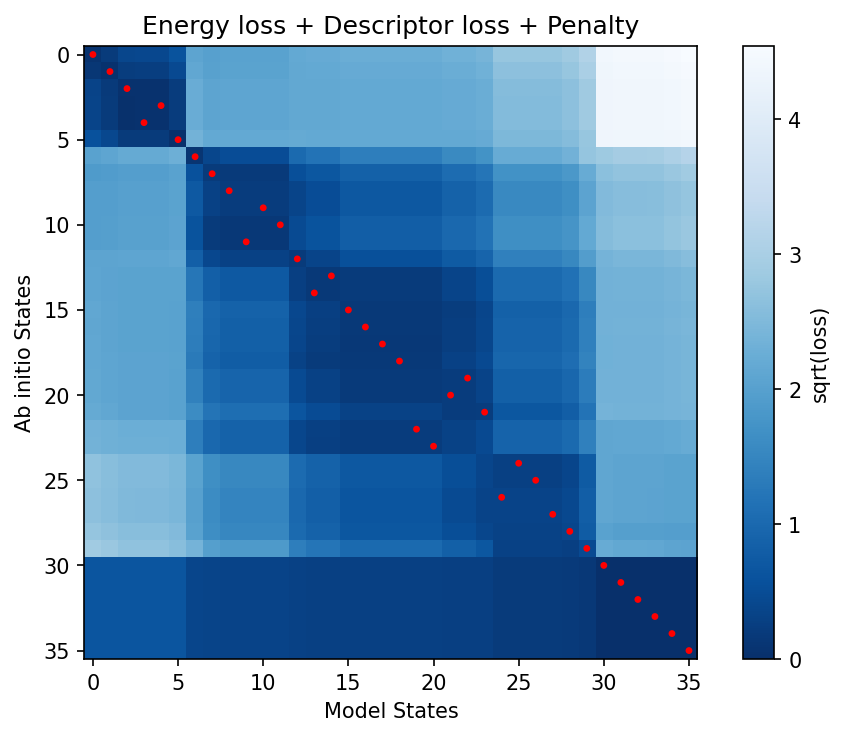

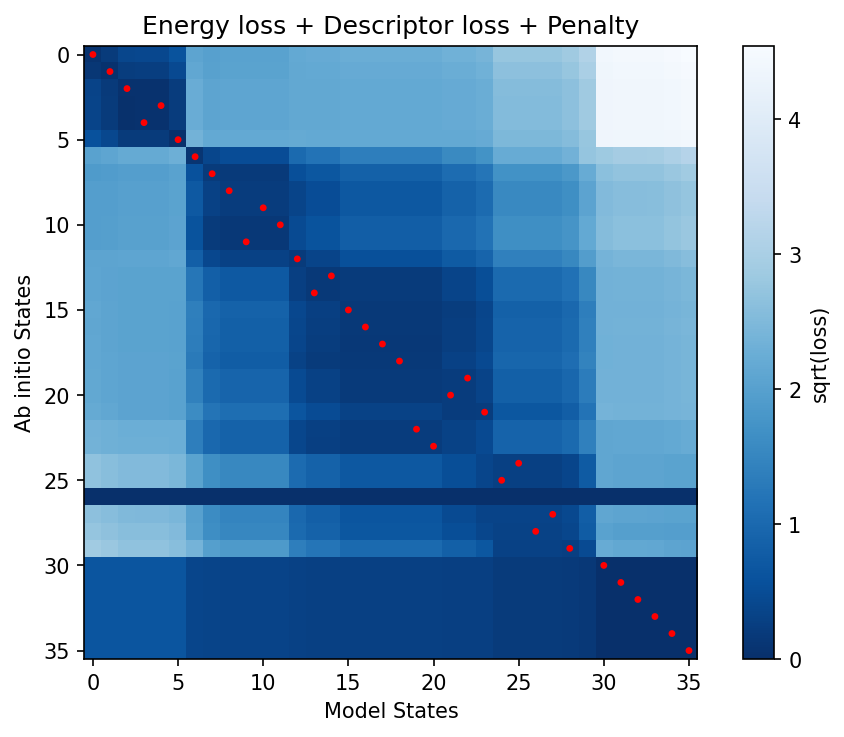

In [114]:
plot_loss2(d_new, dpi=300)

plot_loss2(d2_oneout_new, dpi=300)

In [82]:
p_out_states = [26, 4, 21, 14, 9]

d_five = new_evaluate_loss(params = [-.02, .33, -.5], 
              keys = ['t','U','E0'],  
              onebody = onebody, 
              twobody = twobody, 
              ai_df = ai_df.drop(p_out_states, axis=0), 
              nroots = 36, 
              matches = ['t','U'], 
              norm = 2 * np.var(ai_df),
              weights=weights,
              max_ai_energy=np.max(ai_df['energy']))

d_five_new = insert_missing_back_2(d_five, p_out_states)

[ 4  9 14 21 26]


/home/sjoshi/anaconda3/envs/pyscf_fci_bug/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


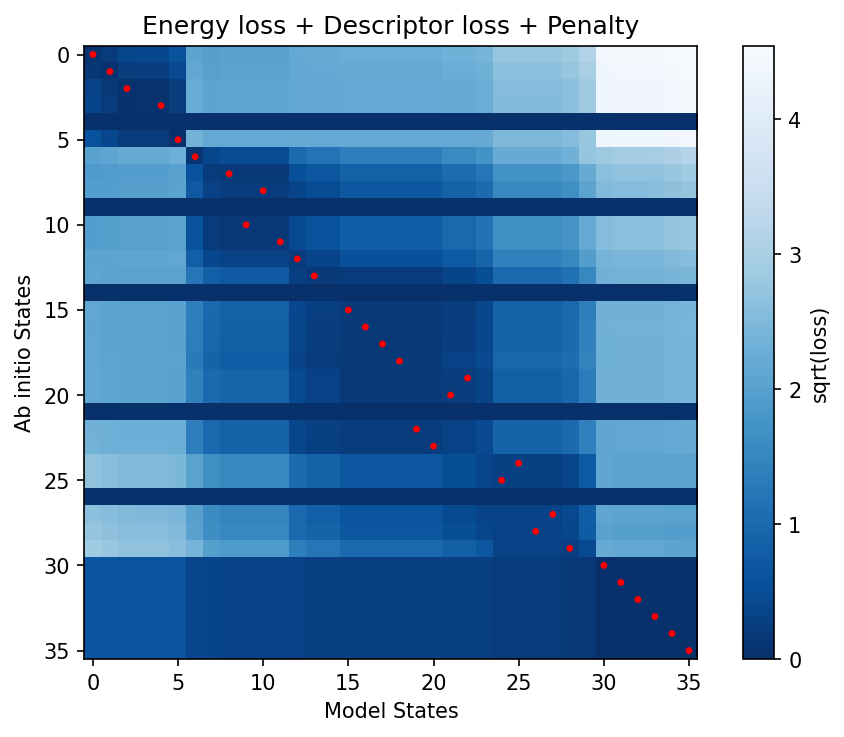

In [83]:
plot_loss2(d_five_new, dpi=150)

In [86]:
p_out_states = [26, 4, 21, 14, 9, 3, 29, 7, 17, 1]

d_ten = new_evaluate_loss(params = [-.02, .33, -.5], 
              keys = ['t','U','E0'],  
              onebody = onebody, 
              twobody = twobody, 
              ai_df = ai_df.drop(p_out_states, axis=0), 
              nroots = 36, 
              matches = ['t','U'], 
              norm = 2 * np.var(ai_df),
              weights=weights,
              max_ai_energy=np.max(ai_df['energy']))

d_ten_new = insert_missing_back_2(d_ten, p_out_states)

/home/sjoshi/anaconda3/envs/pyscf_fci_bug/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


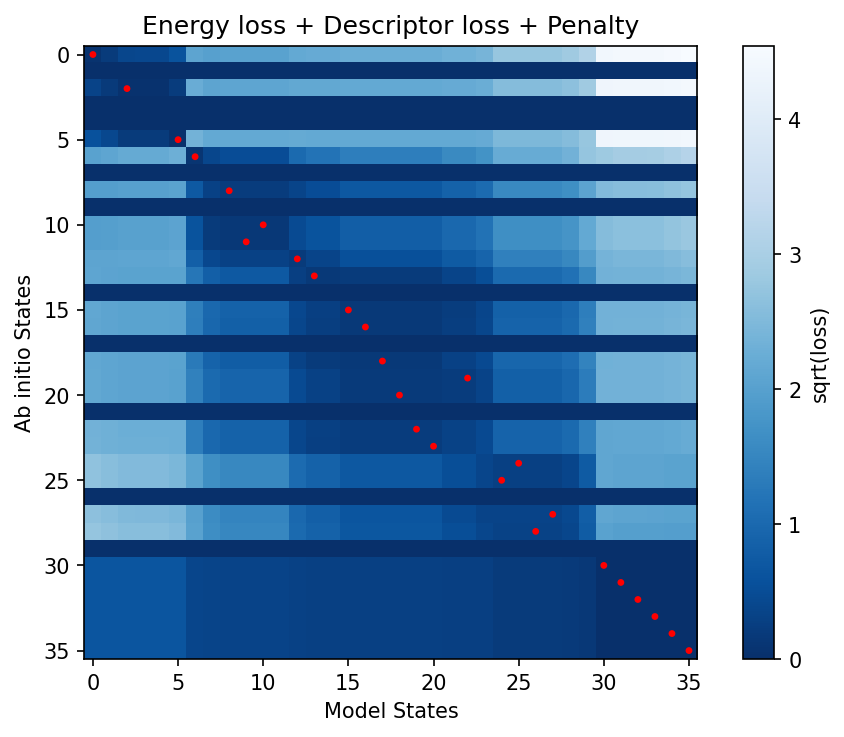

In [87]:
plot_loss2(d_ten_new, dpi=150)

#### Changing how you drop the data from ai_df

Both drop 3 states from the ai_df. The first method is by dropping the data. The second is making the ai_df data 0.

In [101]:
p_out_states = [26, 4, 21]

d_drop1 = new_evaluate_loss(params = [-.02, .33, -.5], 
              keys = ['t','U','E0'],  
              onebody = onebody, 
              twobody = twobody, 
              ai_df = ai_df.drop(p_out_states, axis=0), 
              nroots = 36, 
              matches = ['t','U'], 
              norm = 2 * np.var(ai_df),
              weights=weights,
              max_ai_energy=np.max(ai_df['energy']))
d_drop1_new = insert_missing_back_2(d_drop1, p_out_states)


ai_df2 = ai_df.copy()
ai_df2.loc[p_out_states] = 0
d_drop2 = new_evaluate_loss(params = [-.02, .33, -.5], 
              keys = ['t','U','E0'],  
              onebody = onebody, 
              twobody = twobody, 
              ai_df = ai_df2, 
              nroots = 36, 
              matches = ['t','U'], 
              norm = 2 * np.var(ai_df),
              weights=weights,
              max_ai_energy=np.max(ai_df['energy']))

/home/sjoshi/anaconda3/envs/pyscf_fci_bug/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/sjoshi/anaconda3/envs/pyscf_fci_bug/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


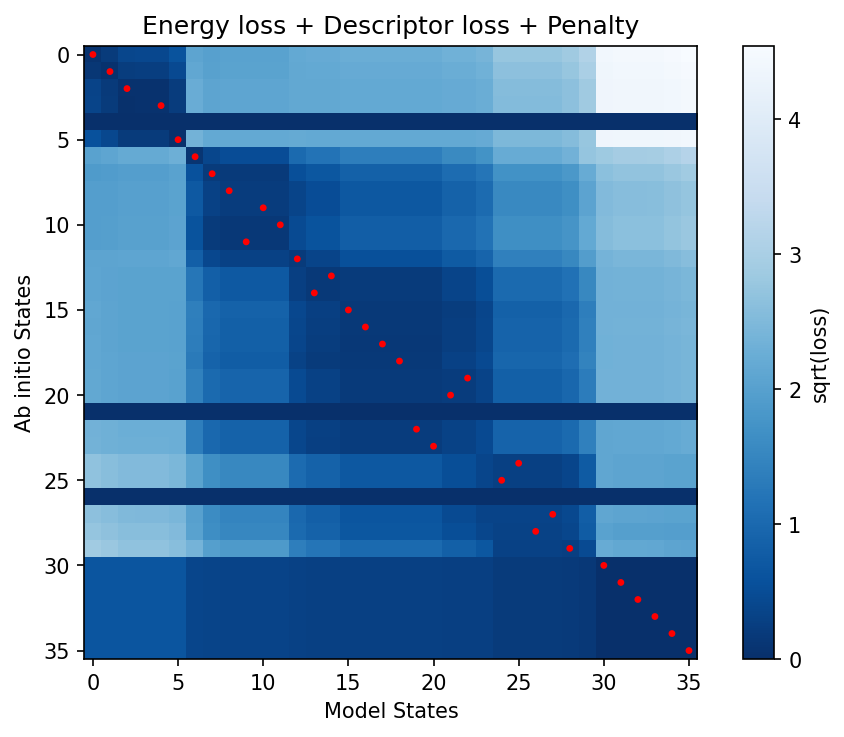

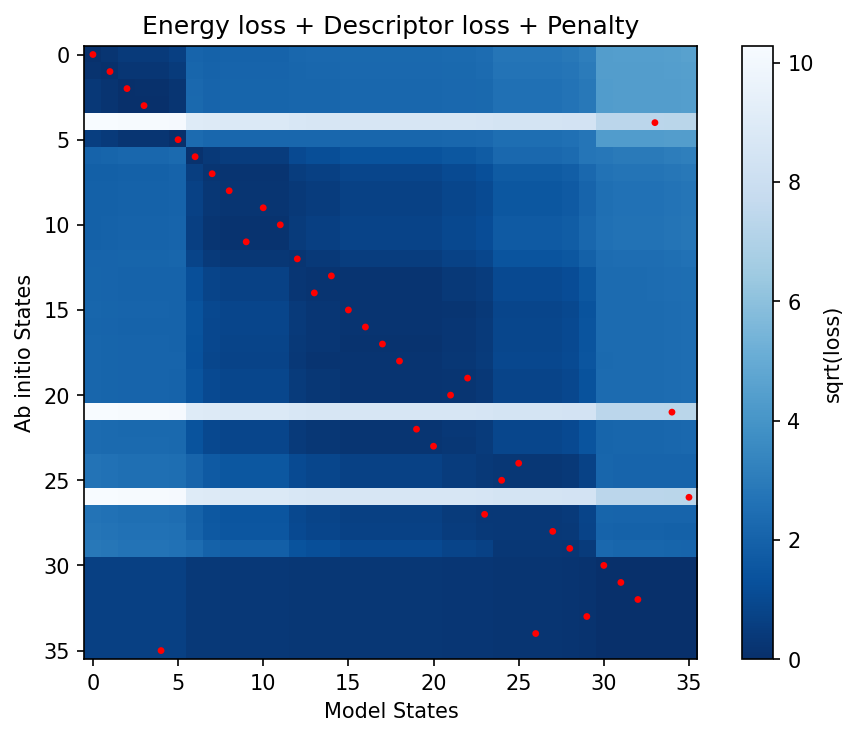

In [102]:
plot_loss2(d_drop1_new, dpi=150)
plot_loss2(d_drop2, dpi=150)